# Train Novel Communications

The [Train Basic Communications](./train_basic_comms.ipynb) notebook demonstrated how we could build a simple one-way communication system using `torchradio`. Since we are free to define whatever objective function we like, we train radios for more interesting mulitple-input multiple-output scenarios.

Let us begin by defining some common building blocks.

In [1]:
import functools
import operator

import numpy as np
import pandas as pd
import plotly.express as px
import torch
from IPython.display import Image
from torch import nn
from tqdm import tqdm

from torchradio import Receiver, Transmitter
from torchradio.algorithm.example import (
    DenseReceptionAlgorithm,
    DenseTransmissionAlgorithm,
)
from torchradio.algorithm.utils import get_all_parameters
from torchradio.env.null import RandomAWGNEnvironment

For each scenario, we use the same environment as [Train Basic Communications](./train_basic_comms.ipynb). Each scenario will contain multiple radios composed of `DenseTransmissionAlgorithm`s and `DenseReceptionAlgorithm`s.

In [2]:
env = RandomAWGNEnvironment(0, 1.0)

## Single Transmitter Dual Receiver

We first envisage a scenario with a one transmitter and two receivers. The transmitter must send a different mesage to each receiver.

In [3]:
n_bits_per_channel = 8
transmitters = {
    "tx": Transmitter(DenseTransmissionAlgorithm(2 * n_bits_per_channel, 4)),
}
receivers = {
    k: Receiver(DenseReceptionAlgorithm(n_bits_per_channel, 64)) for k in ["rx1", "rx2"]
}
env.place(transmitters, receivers)

Next, define a training loop. We divide `device_logs.tx["tx"].metadata["bits"]` down the middle, with the first half intended for `"rx1"` and the second half for `"rx2"`.

In [4]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(
    get_all_parameters(list(transmitters.values()), list(receivers.values())),
    lr=5e-4,
)


def _train(
    n_timesteps: int,
    batch_size: int,
) -> dict[str, float]:
    optimizer.zero_grad()

    device_logs = env.simulate(n_timesteps, batch_size)

    tx_bits = device_logs.tx["tx"].metadata["bits"]
    rx_outputs = {k: v["bit_probabilities"] for k, v in device_logs.rx.items()}
    rx_bits = {k: v["bits"] for k, v in device_logs.rx.items()}

    # compute loss, gradient and update parameters
    rx1_loss = loss_fn(rx_outputs["rx1"], tx_bits.float()[:, :n_bits_per_channel])
    rx2_loss = loss_fn(rx_outputs["rx2"], tx_bits.float()[:, n_bits_per_channel:])
    loss = rx1_loss + rx2_loss
    loss.backward()
    optimizer.step()

    return {
        "rx1_loss": float(rx1_loss.detach().numpy()),
        "rx2_loss": float(rx2_loss.detach().numpy()),
        "rx1_accuracy": float(
            np.mean((tx_bits[:, :n_bits_per_channel] == rx_bits["rx1"]).numpy()),
        ),
        "rx2_accuracy": float(
            np.mean((tx_bits[:, n_bits_per_channel:] == rx_bits["rx2"]).numpy()),
        ),
    }

In [5]:
# track metrics over time
rx1_losses = []
rx2_losses = []
rx1_bit_error_rates = []
rx2_bit_error_rates = []

n_iterations = 2000
batch_size = 10
n_timesteps = 64

for _ in tqdm(range(n_iterations)):
    train_logs = _train(n_timesteps, batch_size)

    rx1_losses.append(train_logs["rx1_loss"])
    rx2_losses.append(train_logs["rx2_loss"])
    rx1_bit_error_rates.append(1 - train_logs["rx1_accuracy"])
    rx2_bit_error_rates.append(1 - train_logs["rx2_accuracy"])

100%|██████████| 2000/2000 [00:02<00:00, 740.45it/s]


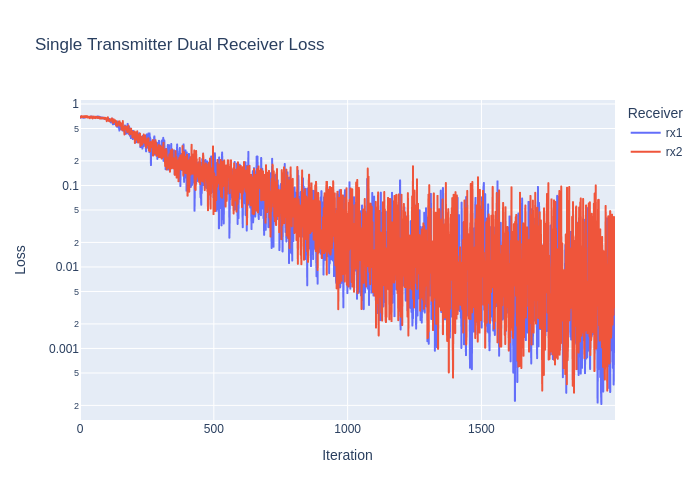

In [6]:
losses = [*rx1_losses, *rx2_losses]
iterations = [*list(range(n_iterations)), *list(range(n_iterations))]
receiver_names = ["rx1" for _ in range(n_iterations)] + [
    "rx2" for _ in range(n_iterations)
]

fig = px.line(
    pd.DataFrame({"Receiver": receiver_names, "Iteration": iterations, "Loss": losses}),
    x="Iteration",
    y="Loss",
    color="Receiver",
    log_y=True,
    title="Single Transmitter Dual Receiver Loss",
)
Image(fig.to_image(format="png"))

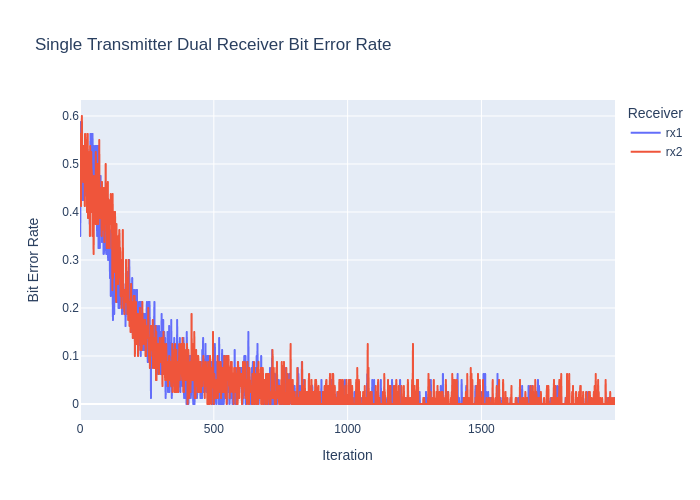

In [7]:
bit_error_rates = [*rx1_bit_error_rates, *rx2_bit_error_rates]

fig = px.line(
    pd.DataFrame(
        {
            "Receiver": receiver_names,
            "Iteration": iterations,
            "Bit Error Rate": bit_error_rates,
        },
    ),
    x="Iteration",
    y="Bit Error Rate",
    color="Receiver",
    log_y=False,
    title="Single Transmitter Dual Receiver Bit Error Rate",
)
Image(fig.to_image(format="png"))

## Dual Transmitter Single Receiver

Next, we envisage a scenario with two transmitters and one receivers. The receiver must successfully decode the messages being received from both transmitters. We follow similar steps from before.

In [8]:
n_bits_per_channel = 8
transmitters = {
    k: Transmitter(DenseTransmissionAlgorithm(n_bits_per_channel, 4))
    for k in ["tx1", "tx2"]
}
receivers = {"rx": Receiver(DenseReceptionAlgorithm(2 * n_bits_per_channel, 32))}
env.place(transmitters, receivers)

We define a similar training loop to before. This time, we divide `device_logs.rx["rx"]["bits"]` down the middle, with the first half intended for `"tx1"` and the second half for `"tx2"`.

In [9]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(
    get_all_parameters(list(transmitters.values()), list(receivers.values())),
    lr=5e-4,
)


def _train(
    n_timesteps: int,
    batch_size: int,
) -> dict[str, float]:
    optimizer.zero_grad()

    device_logs = env.simulate(n_timesteps, batch_size)

    tx_bits = {k: v.metadata["bits"] for k, v in device_logs.tx.items()}
    rx_outputs = device_logs.rx["rx"]["bit_probabilities"]
    rx_bits = device_logs.rx["rx"]["bits"]

    # compute loss, gradient and update parameters
    tx1_loss = loss_fn(rx_outputs[:, :n_bits_per_channel], tx_bits["tx1"].float())
    tx2_loss = loss_fn(rx_outputs[:, n_bits_per_channel:], tx_bits["tx2"].float())
    loss = tx1_loss + tx2_loss
    loss.backward()
    optimizer.step()

    return {
        "tx1_loss": float(tx1_loss.detach().numpy()),
        "tx2_loss": float(tx2_loss.detach().numpy()),
        "tx1_accuracy": float(
            np.mean((tx_bits["tx1"] == rx_bits[:, :n_bits_per_channel]).numpy()),
        ),
        "tx2_accuracy": float(
            np.mean((tx_bits["tx2"] == rx_bits[:, n_bits_per_channel:]).numpy()),
        ),
    }

Train!

In [10]:
# track metrics over time
tx1_losses = []
tx2_losses = []
tx1_bit_error_rates = []
tx2_bit_error_rates = []

n_iterations = 3000
batch_size = 20
n_timesteps = 32

for _ in tqdm(range(n_iterations)):
    train_logs = _train(n_timesteps, batch_size)

    tx1_losses.append(train_logs["tx1_loss"])
    tx2_losses.append(train_logs["tx2_loss"])
    tx1_bit_error_rates.append(1 - train_logs["tx1_accuracy"])
    tx2_bit_error_rates.append(1 - train_logs["tx2_accuracy"])

100%|██████████| 3000/3000 [00:04<00:00, 747.66it/s]


We can plot the losses for each transmitter.

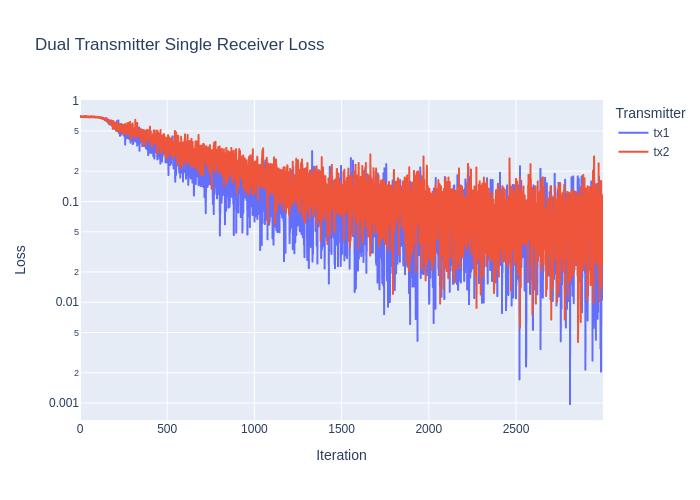

In [11]:
losses = [*tx1_losses, *tx2_losses]
iterations = [*list(range(n_iterations)), *list(range(n_iterations))]
transmitter_names = ["tx1" for _ in range(n_iterations)] + [
    "tx2" for _ in range(n_iterations)
]

fig = px.line(
    pd.DataFrame(
        {"Transmitter": transmitter_names, "Iteration": iterations, "Loss": losses},
    ),
    x="Iteration",
    y="Loss",
    color="Transmitter",
    log_y=True,
    title="Dual Transmitter Single Receiver Loss",
)
Image(fig.to_image(format="png"))

As well as the bit error rates...

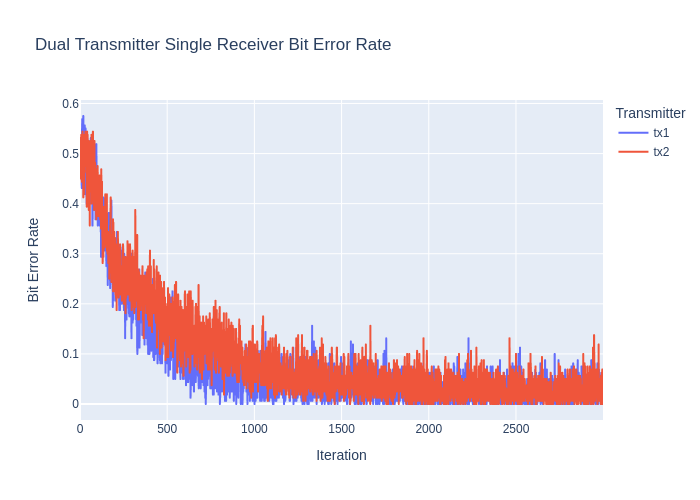

In [12]:
bit_error_rates = [*tx1_bit_error_rates, *tx2_bit_error_rates]

fig = px.line(
    pd.DataFrame(
        {
            "Transmitter": transmitter_names,
            "Iteration": iterations,
            "Bit Error Rate": bit_error_rates,
        },
    ),
    x="Iteration",
    y="Bit Error Rate",
    color="Transmitter",
    log_y=False,
    title="Dual Transmitter Single Receiver Bit Error Rate",
)
Image(fig.to_image(format="png"))

Interestingly, these experiments indicate that it is harder to receive two simultaneous signals than it is to transmit two simultaneous signals.

## Channel Sharing

Finally, we look at a scenario where multiple radios need to share the same band. We will define three `DenseRadio`s and train them to share the spectrum with one another.

In [13]:
n_radios = 3
transmitters = {
    f"tx{i}": Transmitter(DenseTransmissionAlgorithm(16, 4)) for i in range(n_radios)
}
receivers = {
    f"rx{i}": Receiver(DenseReceptionAlgorithm(16, 64)) for i in range(n_radios)
}
env.place(transmitters, receivers)

In [14]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(
    get_all_parameters(list(transmitters.values()), list(receivers.values())),
    lr=5e-4,
)


def _train(
    n_timesteps: int,
    batch_size: int,
) -> dict[str, float]:
    optimizer.zero_grad()

    device_logs = env.simulate(n_timesteps, batch_size)

    tx_bits = {k: v.metadata["bits"] for k, v in device_logs.tx.items()}
    rx_outputs = {k: v["bit_probabilities"] for k, v in device_logs.rx.items()}
    rx_bits = {k: v["bits"] for k, v in device_logs.rx.items()}

    # compute loss, gradient and update parameters
    losses = [
        loss_fn(rx_outputs[f"rx{i}"], tx_bits[f"tx{i}"].float())
        for i in range(n_radios)
    ]
    loss = sum(losses)
    loss.backward()
    optimizer.step()

    accuracies = [
        float(np.mean((tx_bits[f"tx{i}"] == rx_bits[f"rx{i}"]).numpy()))
        for i in range(n_radios)
    ]

    return {
        "losses": [float(l_.detach().numpy()) for l_ in losses],
        "accuracies": accuracies,
    }

In [15]:
# track metrics over time
losses = []
accuracies = []

n_iterations = 4000
batch_size = 10
n_timesteps = 64

for _ in tqdm(range(n_iterations)):
    train_logs = _train(n_timesteps, batch_size)
    losses.append(train_logs["losses"])
    accuracies.append(train_logs["accuracies"])

100%|██████████| 4000/4000 [00:09<00:00, 421.15it/s]


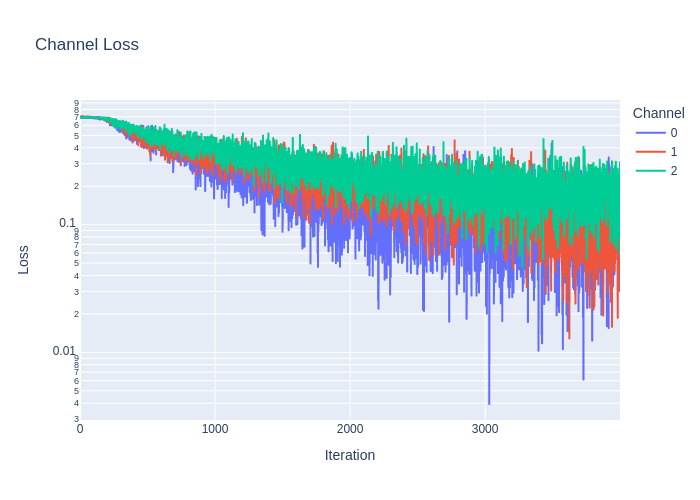

In [16]:
results = pd.DataFrame(
    {
        "Channel": functools.reduce(
            operator.iadd, [list(range(n_radios)) for _ in range(n_iterations)], []
        ),
        "Iteration": functools.reduce(
            operator.iadd,
            [[i for _ in range(n_radios)] for i in range(n_iterations)],
            [],
        ),
        "Loss": functools.reduce(operator.iadd, losses, []),
        "Bit Error Rate": 1
        - torch.tensor(functools.reduce(operator.iadd, accuracies, [])),
    },
)

fig = px.line(
    results,
    x="Iteration",
    y="Loss",
    color="Channel",
    log_y=True,
    title="Channel Loss",
)
Image(fig.to_image(format="png"))

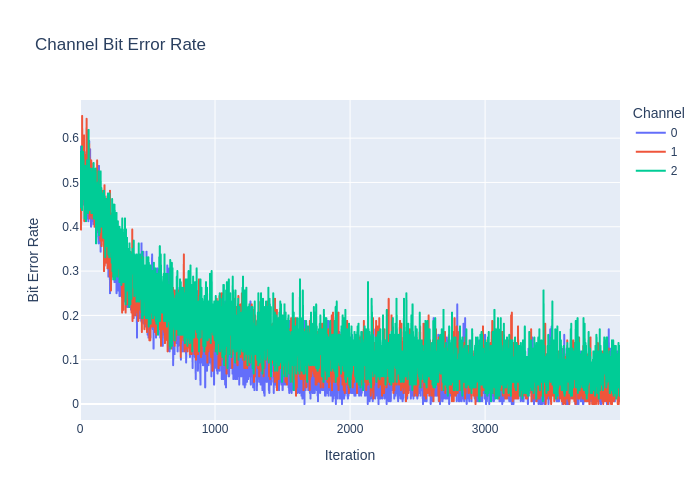

In [17]:
fig = px.line(
    results,
    x="Iteration",
    y="Bit Error Rate",
    color="Channel",
    log_y=False,
    title="Channel Bit Error Rate",
)
Image(fig.to_image(format="png"))